kobart-base-v2 파인튜닝  https://huggingface.co/gogamza/kobart-base-v2  
- 신문기사 총 240,848건 중 192,678건 학습(80%), 48,797건 테스트(20%)  
- 모델링 - 옵티마이저 adamw, learning rate 5e-5, 에포크 3, 배치사이즈 8
- 1에포크당 약 40분, 테스트데이터로 predict 약 2시간 소요  
- 평가 BLEU score: 0.2908318578082472 <-생성된 단어들이 정답 문장에 얼만큼 포함되어 있는지를 확인  
- colab A100 GPU 사용

## 데이터 전처리

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import pandas as pd
import json
import os

import torch
from transformers import PreTrainedTokenizerFast
from transformers import BartForConditionalGeneration

from transformers import AutoTokenizer, DataCollatorWithPadding
import argparse
from collections import defaultdict

from transformers import BartForConditionalGeneration, PreTrainedTokenizerFast
from transformers.optimization import AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModelForCausalLM
import pyarrow.parquet as pq

from datasets import load_dataset
from tqdm.auto import tqdm

In [ ]:
folder_path = 'data/train/'
json_files = [file for file in os.listdir(folder_path) if file.endswith('.json')]

data_list = []

for file_name in json_files:
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
        data_list.append(json_data)

def extract_dict_from_list(input_list):
    filtered_dicts = [item for item in input_list if isinstance(item, dict)]

    result_dict = {}
    for d in filtered_dicts:
        result_dict.update(d)

    return result_dict

data = extract_dict_from_list(data_list)



documents = data['documents']
text_list = []
abstractive_list = []

for doc in documents:
    text_sections = doc['text']
    abstractive_sections = doc['abstractive']

    text = []
    for section in text_sections:
        for sentence_info in section:
            text.append(sentence_info['sentence'])

    sentences_combined = ' '.join(text)
    text_list.append(sentences_combined)

    abstractive_list.extend(abstractive_sections)


df = pd.DataFrame({
    'text': text_list,
    'abstractive': abstractive_list
})

In [ ]:
# # 원본-요약본 딕셔너리

# dataset = {row['text']: row['abstractive'] for _, row in df.iterrows()}

In [ ]:
df.to_pickle('data.pickle')

데이터셋 로드

In [ ]:
from datasets import load_dataset

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
  

In [4]:
dataset_tmp = load_dataset("pandas", data_files="/content/gdrive/MyDrive/Colab Notebooks/final project/data.pickle")
dataset = dataset_tmp['train']

/usr/local/lib/python3.10/dist-packages/datasets/packaged_modules/pandas/pandas.py:27: FutureWarning: The Pandas builder is deprecated and will be removed in the next major version of datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

모델, 토크나이저 로드

In [5]:
model_id = 'gogamza/kobart-base-v2'
tokenizer = AutoTokenizer.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


tokenizer.json:   0%|          | 0.00/682k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/4.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


토크나이징 test

In [6]:
print(tokenizer.tokenize(dataset[0]['abstractive']))

['▁전라', '남', '도가', '▁쌀', '▁과잉', '문제를', '▁근본적으로', '▁해결하기', '▁위해', '▁올해부터', '▁벼', '를', '▁심', '었던', '▁논', '에', '▁벼', '▁대신', '▁사', '료', '작', '물', '이나', '▁콩', '▁등', '▁다른', '▁작', '물을', '▁심', '으면', '▁벼', '와의', '▁일정', '▁소득', '차를', '▁보전', '해주는', "▁'", '쌀', '▁생산', '조정', '제', "'를", '▁적극적으로', '▁시행', '하기로', '▁하고', '▁오는', '▁22', '일부터', '▁2월', '▁28', '일까지', '▁농', '지', '▁소재', '지', '▁읍', '면', '동', '사무', '소에서', '▁신청', '받는', '다', '▁.']


Text(0, 0.5, 'rate')

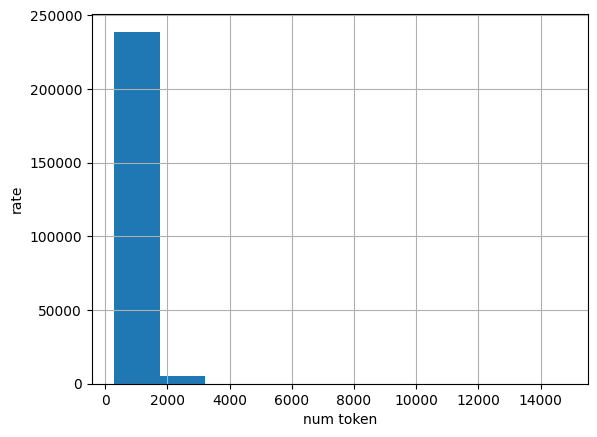

In [7]:
# 원문 24만개의 대다수가 0~2000토큰

import pandas as pd

tmp = pd.DataFrame(dataset)

ax = tmp['text'].str.len().hist()

ax.set_xlabel('num token')
ax.set_ylabel('rate')

Text(0, 0.5, 'rate')

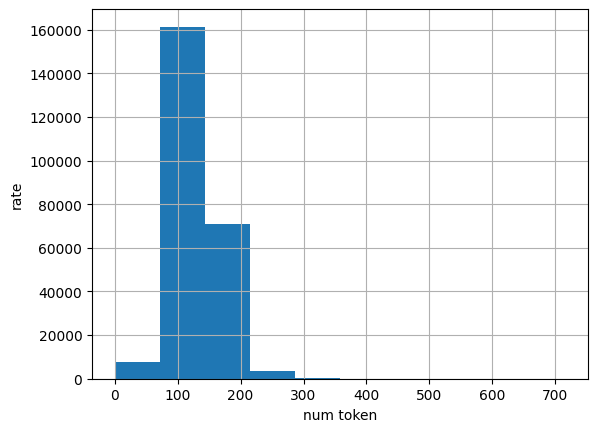

In [8]:
import pandas as pd

tmp = pd.DataFrame(dataset)

ax = tmp['abstractive'].str.len().hist()

ax.set_xlabel('num token')
ax.set_ylabel('rate')

## 텍스트 전처리

입력 텍스트/요약본 형식의 format으로 나누고,   
나눌 때 각각 토크나이저로 인코딩을 하고 그것을 instruct_format의 텍스트 부분에 인코딩된 토큰을 사용  

In [9]:
instruct_format = """
##text: {instruction}


##summary:"""

In [10]:
def padd_texts(items, max_seq_length):
    padded_tokens = []
    padded_labels = []

    eos_token_id = tokenizer.eos_token_id
    pad_token_id = tokenizer.pad_token_id

    for iter, item in enumerate(tqdm(items)):
        if(len(item['text']) > 900):
            continue

        instruction = instruct_format.format(instruction=item['text'])
        output = item['abstractive']

        instruction = tokenizer.encode(instruction)
        output = tokenizer.encode(output)

        padded_tokens.extend(instruction + output)
        padded_tokens.append(eos_token_id)
        for i in range(max_seq_length):
            padded_tokens.append(pad_token_id)

        padded_labels.extend([-100] * len(instruction) + output)
        padded_labels.append(eos_token_id)
        for i in range(max_seq_length):
            padded_labels.append(pad_token_id)

        while len(padded_labels) > max_seq_length:
            yield{
                "input_ids" : torch.tensor(
                    padded_tokens[:max_seq_length],
                    dtype=torch.int64
                ),
                "labels" : torch.tensor(
                    padded_labels[1:max_seq_length + 1],
                    dtype=torch.int64
                )
            }
            padded_tokens = []
            padded_labels = []



padded_tokens = padd_texts(
    dataset.select(range(4)), 
    1024
)

for i, padd in enumerate(padded_tokens):
    print("#", i)
    print(tokenizer.decode(padd["input_ids"], skip_special_tokens=False))
    print(padd["labels"])

  0%|          | 0/4 [00:00<?, ?it/s]

# 0

##text: ha당 조사료 400만원...작물별 차등 지원 이성훈 sinawi@hanmail.net 전라남도가 쌀 과잉문제를 근본적으로 해결하기 위해 올해부터 시행하는 쌀 생산조정제를 적극 추진키로 했다. 쌀 생산조정제는 벼를 심었던 논에 벼 대신 사료작물이나 콩 등 다른 작물을 심으면 벼와의 일정 소득차를 보전해주는 제도다. 올해 전남의 논 다른 작물 재배 계획면적은 전국 5만ha의 약 21%인 1만 698ha로, 세부시행지침을 확정, 시군에 통보했다. 지원사업 대상은 2017년산 쌀 변동직불금을 받은 농지에 10a(300평) 이상 벼 이외 다른 작물을 재배한 농업인이다. 지원 대상 작물은 1년생을 포함한 다년생의 모든 작물이 해당되나 재배 면적 확대 시 수급과잉이 우려되는 고추, 무, 배추, 인삼, 대파 등 수급 불안 품목은 제외된다. 농지의 경우도 이미 다른 작물 재배 의무가 부여된 간척지, 정부매입비축농지, 농진청 시범사업, 경관보전 직불금 수령 농지 등은 제외될 예정이다. ha(3000평)당 지원 단가는 평균 340만원으로 사료작물 400만원, 일반작물은 340만원, 콩·팥 등 두류작물은 280만원 등이다. 벼와 소득차와 영농 편이성을 감안해 작물별로 차등 지원된다. 논에 다른 작물 재배를 바라는 농가는 오는 22일부터 2월 28일까지 농지 소재지 읍면동사무소에 신청해야 한다. 전남도는 도와 시군에 관련 기관과 농가 등이 참여하는‘논 타작물 지원사업 추진협의회’를 구성, 지역 특성에 맞는 작목 선정 및 사업 심의 등을 본격 추진할 방침이다. 최향철 전라남도 친환경농업과장은 “최근 쌀값이 다소 상승추세에 있으나 매년 공급과잉에 따른 가격 하락으로 쌀농가에 어려움이 있었다”며“쌀 공급과잉을 구조적으로 해결하도록 논 타작물 재배 지원사업에 많이 참여해주길 바란다”고 말했다.


##summary: 전라남도가 쌀 과잉문제를 근본적으로 해결하기 위해 올해부터 벼를 심었던 논에 벼 대신 사료작물이나 콩 등 다른 작물을 심으면 벼와의 일정 소득차를 보전

1024 <- kobart가 처리할 수 있는 최대 토큰개수  
텍스트/요약으로 되어 있고, 남는 공간은 \<pad>값으로 처리됨

In [11]:
from pprint import pprint
from torch.utils.data import Dataset, DataLoader, random_split

batch_size = 8
max_seq_length = 1024

dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
test_size = dataset_size - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
padded_dataset = [padd for padd in padd_texts(train_dataset, max_seq_length)]

training_loader = torch.utils.data.DataLoader(
    padded_dataset,
    batch_size=batch_size
)

batch = next(iter(training_loader))

pprint(batch)

pprint(tokenizer.batch_decode(batch["input_ids"], skip_special_tokens=False))

  0%|          | 0/195186 [00:00<?, ?it/s]

{'input_ids': tensor([[14095,   234,   234,  ...,     3,     3,     3],
        [14095,   234,   234,  ...,     3,     3,     3],
        [14095,   234,   234,  ...,     3,     3,     3],
        ...,
        [14095,   234,   234,  ...,     3,     3,     3],
        [14095,   234,   234,  ...,     3,     3,     3],
        [14095,   234,   234,  ...,     3,     3,     3]]),
 'labels': tensor([[-100, -100, -100,  ...,    3,    3,    3],
        [-100, -100, -100,  ...,    3,    3,    3],
        [-100, -100, -100,  ...,    3,    3,    3],
        ...,
        [-100, -100, -100,  ...,    3,    3,    3],
        [-100, -100, -100,  ...,    3,    3,    3],
        [-100, -100, -100,  ...,    3,    3,    3]])}
['\n'
 '##text: 김호일 한국무역보험공사 투자금융본부장(왼쪽)이 지난 1일(현지시간) 아랍에미리트 아부다비 ANDOC 본사에서 아메드 자심 '
 '알 자비 ADNOC 본부장과 업무 협약 체결 후 악수를 하고 있다. 한국무역보험공사는 지난 1일(현지시간) 아랍에미리트(UAE)에서 '
 '아부다비 국영석유회사(ADNOC)와 30억 달러 중장기 금융 한도를 제공하는 협약을 체결했다고 2일 밝혔다. 공사는 협약 체결일로부터 '
 '3년간 ADNOC의 해외사업에 대해 최대 30억 달러의 해외사업 금융보험

모델과 파라미터 수 확인

In [12]:
model = AutoModelForCausalLM.from_pretrained(model_id)
model

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


model.safetensors:   0%|          | 0.00/495M [00:00<?, ?B/s]

Some weights of BartForCausalLM were not initialized from the model checkpoint at gogamza/kobart-base-v2 and are newly initialized: ['decoder.embed_tokens.weight', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BartForCausalLM(
  (model): BartDecoderWrapper(
    (decoder): BartDecoder(
      (embed_tokens): BartScaledWordEmbedding(30000, 768, padding_idx=3)
      (embed_positions): BartLearnedPositionalEmbedding(1028, 768)
      (layers): ModuleList(
        (0-5): 6 x BartDecoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (activation_fn): GELUActivation()
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (encoder_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_feat

In [13]:
def count_parameters(model):
    params = sum(p.numel() for name, p in model.named_parameters())
    return params

print("total params:", count_parameters(model))

total params: 80541696


## 모델 학습

In [14]:
is_cuda = torch.cuda.is_available()
is_cuda

device = torch.device('cuda' if is_cuda else 'cpu')
model.to(device)
model.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

In [15]:
from tqdm.auto import tqdm
import torch.nn.functional as F

def change_dict_device(x):
    return {k: v.to(device) for k, v in x.items()}

running_loss = 0.
last_loss = 0.
log_freq = 50
i = 0

# 3에폭 학습하기

total_epochs = 3

model.train()
for epoch in range(total_epochs):
    for batch in tqdm(training_loader, desc=f"Epoch {epoch}"):
        i += 1

        optimizer.zero_grad()
        batch = change_dict_device(batch)

        logits = model(batch['input_ids']).logits

        logits = logits.view(-1, logits.shape[-1])
        labels = batch["labels"].view(-1)

        loss = F.cross_entropy(logits, labels, ignore_index=-100)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % log_freq == 0:
            last_loss = running_loss / log_freq
            print('batch {} loss : {}'.format(i + 1, last_loss))
            running_loss = 0.

Epoch 0:   0%|          | 0/11133 [00:00<?, ?it/s]

batch 50 loss : 7.743497657775879
batch 100 loss : 1.5418120539188385
batch 150 loss : 0.9843986284732819
batch 200 loss : 0.8735664331912995
batch 250 loss : 0.7493725073337555
batch 300 loss : 0.7343241262435913
batch 350 loss : 0.7305335307121277
batch 400 loss : 0.7087324476242065
batch 450 loss : 0.6962587881088257
batch 500 loss : 0.7026065182685852
batch 550 loss : 0.696133713722229
batch 600 loss : 0.6864245617389679
batch 650 loss : 0.6945036697387695
batch 700 loss : 0.7071842312812805
batch 750 loss : 0.6944889426231384
batch 800 loss : 0.6924026668071747
batch 850 loss : 0.6789271140098572
batch 900 loss : 0.6777280461788178
batch 950 loss : 0.6936101591587067
batch 1000 loss : 0.6909270787239075
batch 1050 loss : 0.6729882562160492
batch 1100 loss : 0.6917981445789337
batch 1150 loss : 0.6873966515064239
batch 1200 loss : 0.6790073096752167
batch 1250 loss : 0.6688167154788971
batch 1300 loss : 0.6777077984809875
batch 1350 loss : 0.6737918627262115
batch 1400 loss : 0.683

Epoch 1:   0%|          | 0/11133 [00:00<?, ?it/s]

batch 11150 loss : 0.20424367874860763
batch 11200 loss : 0.20584141194820404
batch 11250 loss : 0.20584973692893982
batch 11300 loss : 0.2095772698521614
batch 11350 loss : 0.20400129973888398
batch 11400 loss : 0.21223311603069306
batch 11450 loss : 0.2043597561120987
batch 11500 loss : 0.20196039617061615
batch 11550 loss : 0.200913664996624
batch 11600 loss : 0.2007145804166794
batch 11650 loss : 0.20276359140872954
batch 11700 loss : 0.20231719493865966
batch 11750 loss : 0.19957804173231125
batch 11800 loss : 0.19664609521627427
batch 11850 loss : 0.20373969346284868
batch 11900 loss : 0.20244524478912354
batch 11950 loss : 0.19927343994379043
batch 12000 loss : 0.19996792405843736
batch 12050 loss : 0.20317147701978683
batch 12100 loss : 0.2026335695385933
batch 12150 loss : 0.19905317723751068
batch 12200 loss : 0.2017979860305786
batch 12250 loss : 0.20261964470148086
batch 12300 loss : 0.19984313309192658
batch 12350 loss : 0.20733499974012376
batch 12400 loss : 0.20369943231

Epoch 2:   0%|          | 0/11133 [00:00<?, ?it/s]

batch 22300 loss : 0.17202647447586059
batch 22350 loss : 0.16217382848262787
batch 22400 loss : 0.1733123442530632
batch 22450 loss : 0.16917762368917466
batch 22500 loss : 0.1699447277188301
batch 22550 loss : 0.17017962783575058
batch 22600 loss : 0.16866764590144157
batch 22650 loss : 0.1649048987030983
batch 22700 loss : 0.16366993725299836
batch 22750 loss : 0.16548596680164337
batch 22800 loss : 0.16984774872660638
batch 22850 loss : 0.16382988497614862
batch 22900 loss : 0.16252803310751915
batch 22950 loss : 0.16092922538518906
batch 23000 loss : 0.16936430856585502
batch 23050 loss : 0.16579842805862427
batch 23100 loss : 0.1697570227086544
batch 23150 loss : 0.1614728383719921
batch 23200 loss : 0.17098364263772964
batch 23250 loss : 0.16595780119299888
batch 23300 loss : 0.16156189054250716
batch 23350 loss : 0.17089815586805343
batch 23400 loss : 0.16705083116889
batch 23450 loss : 0.1669001992046833
batch 23500 loss : 0.17312413960695267
batch 23550 loss : 0.1671459278464

In [23]:
torch.save(model.state_dict(), 'model_0738.pth')
model.load_state_dict(torch.load('model_0738.pth'))

<All keys matched successfully>

## 모델 평가

기사 내용 900이상 은 제외하고 test 데이터셋으로 요약 진행

In [51]:
test_dataset

In [58]:
# 인풋텍스트 디코드해서 반환하는 함수


import nltk
import random

def get_answer2(prefix):
  prefix = tokenizer([prefix], return_tensors="pt").to(device)
  outputs = model.generate(prefix['input_ids'], max_new_tokens=128, do_sample=True)

  return tokenizer.decode(outputs[0], skip_special_tokens=True)


BLEUscore_sum = []
print(len(test_dataset))

for i, item in enumerate(tqdm(test_dataset)):
  if(len(item['text']) > 900):
    continue

  input_text = ""
  input_text = instruct_format.format(instruction=item['text'])
  output_text = get_answer2(input_text)

  if(i % 200 == 0):
    print("iter", i)
    print("input", item["text"])
    print("target", item["abstractive"])
    print("pred", output_text[len(input_text):])

  hypothesis = output_text[len(input_text):]
  reference = item['abstractive']
  BLEU = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
  BLEUscore_sum.append(BLEU)


avg = sum(BLEUscore_sum, 0.0) / len(BLEUscore_sum)
print("\n", avg)

48797


  0%|          | 0/48797 [00:00<?, ?it/s]

iter 200
input 김유리 기자 보건의료체계 개혁 등 과제 공유 대한간호협회는 30일 낮 12시 서울 광화문광장에서 ‘2019 간호정책 선포식’을 개최한다고 28일 밝혔다. 대한간호협회는 간호정책 선포식에서 간호법 제정을 촉구하며 ▶국민과 환자를 위한 예방과 건강 증진 중심의 보건의료체계 개혁 ▶지역사회 통합 돌봄 시스템 활성화 ▶간호사와 의사 간 협력적 면허체계 정립 ▶간호인력 수급 불균형 해소 및 근무환경 개선 ▶간호 관계 법령 체계 총정비 및 합리적 간호전달체계 구축 등의 정책과제를 공유할 계획이다. 전국 간호사와 간호대학생 및 간호가족, 재외한인간호사회 등 5만여 명이 참석할 예정이다. 또한 세계보건기구(WHO)의 2020년 세계 간호사의 해 지정 및 나이팅게일 탄생 200주년을 기념하는 행사도 함께 열린다. 국제간호협의회(ICN)와 WHO가 함께 추진하는 ‘널싱 나우 캠페인’ 한국위원회 현황 보고도 예정돼 있다. 이 캠페인은 병원과 지역사회에 간호사를 충분히 배치하고 그 역할을 강화하는 것을 목표로 한다. 이 외에도 트로트 가수 홍진영과 국카스텐, 기리보이, 마크툽, 포르테 디 콰트로 등 다양한 뮤지션이 출연해 공연을 선보일 예정이다. 대한간호협회 측은 "2019 간호정책 선포식은 전국 모든 간호가족이 함께 하는 축제일 뿐 아니라 보건의료전달체계 개혁을 간호사가 선도하겠다는 국민과의 약속"이라며 "간호법 제정을 통해 전문화된 보건의료체계로 혁신하는 데 대한간호협회가 앞장설 것"이라고 밝혔다. 김유리 기자 kyr@kihoilbo.co.kr
target 대한간호협회는 30일 낮 12시 서울 광화문광장에서 전국 간호사와 간호대학생 및 간호가족, 재외한인간호사회 등 5만여 명이 참석한 가운데 ‘2019 간호정책 선포식’을 가질 예정이며 간호법 제정을 통해 전문화된 보건의료체계로 혁신하는 데 대한간호협회가 앞장설 것이라고 28일 밝혔다.
pred  대한 간호협회는 30일 낮 12시 서울 광화문광장에서 '2019 간호정책 선포식'을 열며, 이 자리에서 권

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


iter 400
input 박성철 기자 안산시는 뷰티산업 발전과 종사자의 자긍심을 높이기 위한 취지로 마련된 ‘제1회 안산 K-뷰티 페스티벌’을 성황리에 마무리됐다고 21일 밝혔다. 안산시가 주최하고 신안산대학교 산학협력단 주관으로 안산광장에서 20일 진행된 행사는 화려한 볼거리에 풍성한 즐길 거리로 시민과 관계자 등 5천여 명이 참석한 가운데 뷰티산업의 최근 트렌드를 알렸다. 행사는 오전 11시부터 오후 5시까지 식전행사로 시민들이 직접 즐기며 참여할 수 있는 분위기로 마련돼 ▶뷰티 무료 체험 22개 부스(헤어스타일 연출, 네일아트, 특수분장, 바디페인팅, 타투, 한복체험 등) ▶관내 미용 기자재업체 제품부스 ▶뷰티작품 전시부스 ▶거리 퍼포먼스 등 다채로운 볼거리·즐길 거리가 제공됐다. 이어 오후 5시부터 본 행사를 시작해 백옥수 한복 쇼, 이성범 업스타일 쇼 등 총 6개 팀의 뷰티 트렌드 쇼가 화려하게 선보였으며, 김동명, 뉴타운보이즈, 모니카 등 가수들의 축하공연이 이어졌다. 특히 이날 백옥수 디자이너의 한복 쇼에는 윤화섭 안산시장 내외가 한복을 입고 모델로 깜짝 등장해 고전적인 아름다움에 현대적 감각을 가미한 패션쇼를 선보였다. 윤 시장은 대회사를 통해 "뷰티산업 발전을 위한 아름다운 미의 첫걸음을 오늘 막 뗐다"며 "안산 K-뷰티 페스티벌이 지역을 넘어 국제적인 뷰티 문화축제로 거듭날 수 있도록 많은 관심과 성원을 바란다"고 말했다. 안산=박성철 기자 psc@kihoilbo.co.kr
target 윤화섭 안산시장은 뷰티산업 발전과 종사자의 자긍심을 높이기 위한 '제1회 안산 K-뷰티 페스티벌’ 대회사에서 국제적인 뷰티 문화 축제로 거듭날 수 있도록 성원을 바란다는 말을 전했으며, 행사는 화려한 구경거리와 풍성한 즐길 거리로 5천여 명이 참석한 가운데 성황리에 마무리됐다.
pred  안산시가 주최하고 신안산대학교 산학협력단 주관으로 안산광장에서 '뷰티산업 육페인 페스티벌'을 성황리에 마쳤다고 21일 밝히며 안산시장 내외에서 고전적인 아름다움에 현대적 감

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


iter 1000
input 송종하 기자l song3316@naver.com 전주덕진소방서가 소방차 진입이 곤란한 지역에 비상소화장치를 설치해 빠른 화재대응에 나선다. 전주덕진소방서 현장대응단은 17일 좁은 골목길이 산재해 소방차 진·출입이 어려운 구도심 주택밀집지역에 신속하게 화재에 대응할 수 있도록 비상소화장치(호스릴방식)를 설치했다고 밝혔다. 비상소화장치란 소화전과 소방호스 등을 연결하여 보관하는 장치로 화재발생 시 소방차가 도착하기 전까지 지역주민 누구나 활용해 화재를 진압, 피해를 최소화할 수 있는 장치다. 그동안 구도심 주택밀집지역은 통행로가 협소하고 심야시간 주차차량으로 인해 소방차량의 진입이 어려워 화재 발생 시 초기진화가 곤란해 큰 인명피해와 재산피해가 발생할 우려가 컸다. 이에 현장대응단은 덕진구 관내 팔복동과 동산동에 7개의 비상소화장치를 설치했다. 이번 비상소화장치 설치장소 선정기준은 △소방차량 진입이 어려운 곳 △심야시간 주정차가 극심한 지역 △설치지역 주변(유효반경 내)에 30가구 이상 밀집된 지역 △용수확보가 용이한 지역 등을 고려해 선정했다. 덕진소방서 현장대응단 관계자는 “화재 발생 시 소방차가 현장에 도착하기 전까지 지역 주민들이 비상소화장치를 활용, 초기에 화재에 대응해 인명 및 재산피해가 최소화되길 바란다”고 말했다. /송종하기자·song3316@ 송종하 기자 song3316@naver.com
target 전주덕진소방서 현장대응단은 소방차 진·출입이 어려운 구도심 주택밀집지역에 소화전과 소방호스 등을 연결하여 보관하는 장치를 설치해 화재발생 시 소방차가 도착하기 전까지 누구나 활용해 화재를 진압하여 피해를 최소화할 수 있게 하였다.
pred  전주덕진소방서가 지난 17일 좁은 골목길이 산재해 소방차 진·출입이 어려운 지역 재난 탐치를 설치해 비상소에 대응할 수 있도록 비상소화장치(호스릴방식)를 설치해 화재에 대응해 인명피해와 재산피해가 발생할 우려가 컸다.
iter 1800
input 오승현 기자 뉴발란스 제공 뉴발란스, 새

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


iter 20400
input 박태환 이후 8년만 “도쿄올림픽 출전권 도전" 이기수 기자 김수지(21·울산광역시청)가 지난13일 광주광역시 남부대 시립국제수영장에서 열린 2019광주 수영세계선수권대회 이틀째 다이빙 여자 1ｍ 스프링보드 결승에서 3위를 차지해 한국 다이빙 사상 최초로 세계수영선수권대회 메달을 수확했다. 대회조직위 제공. 편집에디터 김수지(21·울산광역시청)가 한국 다이빙 사상 최초로 세계수영선수권대회 메달을 수확했다. 수영 세계선수권대회에서 박태환 이후 8년 만에 나온 메달이다. 김수지는 13일 광주광역시 남부대 시립국제수영장에서 열린 대회 이틀째 다이빙 여자 1ｍ 스프링보드 결승에서 5차 시기 합계 257.20점을 획득해 3위를 차지했다. 사실 김수지는 메달 후보도 아니었다. 하지만 10년 동안 비인기 종목 다이빙 선수로 뛰며 고된 훈련과 외로움을 견딘 김수지는 역대 한국 선수로는 박태환에 이어 두 번째, 한국 여자 선수로는 최초로 세계수영선수권 시상대에 올랐다. 이번 대회 한국 선수단의 첫 메달이기도 하다. 이 종목 금메달은 중국 천이원(285.45점)에게 , 은메달은 미국 사라 베이컨 ( 262.00점)에게 각각 돌아갔다. 김수지의 목표는 올림픽 종목인 여자 3ｍ 스프링보드에서 결승에 진출해 도쿄 올림픽 출전권을 따는 것이다. 여자 1ｍ 스프링보드는 올림픽 정식종목이 아니다. 김수지”기세를 이어가 도쿄올림픽 출전권을 획득하겠다”고 목소리를 높였다. 김수지는 오는 18일 스프링보드 3m에 출전한다. 이기수 기자
target 울산광역시청 김주지 선수가 13일 광주광역시 남부대 시립국제수영장에서 열린 여자 1ｍ 스프링보드 결승에서 합계 257.20점으로 3위에 랭크되며 박태환 이후 8년만에 한국 다이빙 사상 최초로 세계수영선수권대회 메달을 목에 걸게되었다.
pred 한국 다이빙 사상 최초로 수영 세계선수권대회에서 박태환 이후 8년만에 나온 메달로 63차 시기 합계 257.20점을 획득해 3위를 차지했다.
iter 20600
input 사진 = 

In [ ]:
# 결론 : BLEU score 평균  0.2908318578082472

In [ ]:
# ???

아무 기사 가져와서 test

In [76]:
# test 1

text = "브라질 해역에서 잡힌 상어 13마리가 코카인 반응에서 '양성'이 나왔다. 영국 BBC는 지난 23일(현지시간) 브라질 오스왈도 크루즈 재단이 리우데자네이루 인근 해역에서 포획한 상어 브라질 샤프노즈 13마리를 검사한 결과, 근육과 간에서 고농도의 코카인이 다량 검출됐다고 밝혔다. 길고 뾰족한 주둥이와 큰 눈을 가진 샤프노즈 상어는 주로 해안가 서핑 지역이나 강어귀에서 먹이를 찾아 다녀 사람과 자주 마주치는 물고기 중 하나다. 이번에 검출된 코카인 농도는 기존에 보고된 다른 수생 생물에서 나온 것보다 무려 100배 높은 수치다. 포획한 상어 모두에게서 코카인이 검출됐으나 특히 수컷보다 암컷 상어의 근육에서 더 높은 수준의 코카인이 확인됐다. 전문가들은 불법 마약 제조 실험 시설이나 마약 사용자들의 배설물 때문에 코카인이 바다로 유입됐을 가능성이 높은 것으로 보고 있다. 마약 밀매업체들이 코카인을 해상에서 분실하거나 버렸을 수는 있지만, 이 같은 가능성은 낮다고 분석했다. 전문가들은 상어에 대한 코카인의 영향을 규명하려면 추가 연구가 필요하지만, 약물이 사람과 마찬가지로 동물에게도 유사한 영향을 미칠 가능성이 있다는 이전 연구 결과가 있다고 설명했다. 포르투갈 레이리아 소재 폴리테크닉대학 해양환경과학센터의 해양생태독성학자 사라 노바이스는 이번 결과에 대해 매우 중요하고 우려스럽다고 경고했다. 한편 해당 연구 결과는 국제학술지 '종합환경과학(Science of the Total Environment)'에 게재됐다."



def get_answer2(prefix):
  prefix = tokenizer([prefix], return_tensors="pt").to(device)
  outputs = model.generate(prefix['input_ids'], max_new_tokens=128, do_sample=True)

  return tokenizer.decode(outputs[0], skip_special_tokens=True)


input_text = ""
input_text = instruct_format.format(instruction=text)
output_text = get_answer2(input_text)
output_text

"\n##text: 브라질 해역에서 잡힌 상어 13마리가 코카인 반응에서 '양성'이 나왔다. 영국 BBC는 지난 23일(현지시간) 브라질 오스왈도 크루즈 재단이 리우데자네이루 인근 해역에서 포획한 상어 브라질 샤프노즈 13마리를 검사한 결과, 근육과 간에서 고농도의 코카인이 다량 검출됐다고 밝혔다. 길고 뾰족한 주둥이와 큰 눈을 가진 샤프노즈 상어는 주로 해안가 서핑 지역이나 강어귀에서 먹이를 찾아 다녀 사람과 자주 마주치는 물고기 중 하나다. 이번에 검출된 코카인 농도는 기존에 보고된 다른 수생 생물에서 나온 것보다 무려 100배 높은 수치다. 포획한 상어 모두에게서 코카인이 검출됐으나 특히 수컷보다 암컷 상어의 근육에서 더 높은 수준의 코카인이 확인됐다. 전문가들은 불법 마약 제조 실험 시설이나 마약 사용자들의 배설물 때문에 코카인이 바다로 유입됐을 가능성이 높은 것으로 보고 있다. 마약 밀매업체들이 코카인을 해상에서 분실하거나 버렸을 수는 있지만, 이 같은 가능성은 낮다고 분석했다. 전문가들은 상어에 대한 코카인의 영향을 규명하려면 추가 연구가 필요하지만, 약물이 사람과 마찬가지로 동물에게도 유사한 영향을 미칠 가능성이 있다는 이전 연구 결과가 있다고 설명했다. 포르투갈 레이리아 소재 폴리테크닉대학 해양환경과학센터의 해양생태독성학자 사라 노바이스는 이번 결과에 대해 매우 중요하고 우려스럽다고 경고했다. 한편 해당 연구 결과는 국제학술지 '종합환경과학(Science of the Total Environment)'에 게재됐다.\n\n\n##summary: 지난 23일(현지시간) 브라질 오스왈도 크루즈 재단은 기존의 한국시간규사를 통해 다량 검출됐다고 밝히며 이러한 상어 13마리가 코카인으로 좋지 않은 등 코카인이 안전로 인해 고농도의 코카인이 다량을 검출됐다고 했다. "

In [79]:
# test 2

text = "앞서 관객을 폭행한 혐의로 5000만 달러의 손배소 피소를 당한 미국의 대표 R&B 가수 크리스 브라운이 추가적인 혐의로 고소됐다. 25일(이하 현지시간) 미국 연예매체 피플에 따르면 디키즈 아레나의 직원이자 보안 책임자인 프레드릭 오버펙은 현장에서 일어난 폭행 사태로 척추뼈에 금이 갔고 이 탓에 현재 일을 못하고 있다는 이유로 크리스 브라운을 고소했다. 현재 오버펙은 크리스 브라운에 1500만 달러(한화 207억 원)의 피해 보상을 요구하고 있는 중이다. 앞서 지난 19일 미국 텍사스 디키즈 아레나에서 '11:11' 투어를 진행한 크리스 브라운은 백스테이지에서 관객 4명을 폭행해 5000만 달러(691억 원) 규모의 피해 보상 소송을 당했다. 고소장에 따르면 원고 측은 공연이 끝난 뒤 백스테이지로 초대됐고, 예정보다 30분 늦게 도착한 크리스 브라운과 인사를 나눴다. 이 가운데 크리스 브라운의 지인 중 한 명이 찰스 부시와 과거 있었던 갈등을 언급했고, 이를 들은 크리스 브라운은 돌연 분노를 표하며 주변에 있던 측근들과 함께 찰스 부시를 폭행하기 시작했다. 이들 중 한 명은 찰스 부시의 머리에 의자를 던지기도 했다고. 이를 보고 있던 래리 파커는 자리에서 벗어나려 했으나 크리스 브라운이 이를 막아섰고, 크리스 브라운의 지시에 따라 스태프들은 그의 얼굴과 가슴을 10분 가까이 폭행했다. 현재 폭행을 당한 피해자들은 병원 치료를 받고 있는 것으로 알려졌다. 오버펙도 해당 사건의 피해자 중 하나라 주중하고 있는 상황. 오버펙은 '싸움을 시작한 건 크리스 브라운 쪽이었다. 난 싸움을 말리려 했으나 크리스 브라운과 스태프는 계속 날 쫓아내려 했고, 계단에 갇힌 래리 파커를 구하려다 싸움에 휘말리게 됐다. 그 과정에서 발로 수차례 폭행당했으며 겨우 탈출할 수 있었다'라고 설명했다."
def get_answer2(prefix):
  prefix = tokenizer([prefix], return_tensors="pt").to(device)
  outputs = model.generate(prefix['input_ids'], max_new_tokens=128, do_sample=True)

  return tokenizer.decode(outputs[0], skip_special_tokens=True)


input_text = ""
input_text = instruct_format.format(instruction=text)
output_text = get_answer2(input_text)
output_text

"\n##text: 앞서 관객을 폭행한 혐의로 5000만 달러의 손배소 피소를 당한 미국의 대표 R&B 가수 크리스 브라운이 추가적인 혐의로 고소됐다. 25일(이하 현지시간) 미국 연예매체 피플에 따르면 디키즈 아레나의 직원이자 보안 책임자인 프레드릭 오버펙은 현장에서 일어난 폭행 사태로 척추뼈에 금이 갔고 이 탓에 현재 일을 못하고 있다는 이유로 크리스 브라운을 고소했다. 현재 오버펙은 크리스 브라운에 1500만 달러(한화 207억 원)의 피해 보상을 요구하고 있는 중이다. 앞서 지난 19일 미국 텍사스 디키즈 아레나에서 '11:11' 투어를 진행한 크리스 브라운은 백스테이지에서 관객 4명을 폭행해 5000만 달러(691억 원) 규모의 피해 보상 소송을 당했다. 고소장에 따르면 원고 측은 공연이 끝난 뒤 백스테이지로 초대됐고, 예정보다 30분 늦게 도착한 크리스 브라운과 인사를 나눴다. 이 가운데 크리스 브라운의 지인 중 한 명이 찰스 부시와 과거 있었던 갈등을 언급했고, 이를 들은 크리스 브라운은 돌연 분노를 표하며 주변에 있던 측근들과 함께 찰스 부시를 폭행하기 시작했다. 이들 중 한 명은 찰스 부시의 머리에 의자를 던지기도 했다고. 이를 보고 있던 래리 파커는 자리에서 벗어나려 했으나 크리스 브라운이 이를 막아섰고, 크리스 브라운의 지시에 따라 스태프들은 그의 얼굴과 가슴을 10분 가까이 폭행했다. 현재 폭행을 당한 피해자들은 병원 치료를 받고 있는 것으로 알려졌다. 오버펙도 해당 사건의 피해자 중 하나라 주중하고 있는 상황. 오버펙은 '싸움을 시작한 건 크리스 브라운 쪽이었다. 난 싸움을 말리려 했으나 크리스 브라운과 스태프는 계속 날 쫓아내려 했고, 계단에 갇힌 래리 파커를 구하려다 싸움에 휘말리게 됐다. 그 과정에서 발로 수차례 폭행당했으며 겨우 탈출할 수 있었다'라고 설명했다.\n\n\n##summary: 지난 19일 미국 텍사스 디키즈 아레나에서 '11:11' 투어를 진행한 등 무스테이지에서 관객 4명을 폭행하며 5000만 달러 규모의 피해 보

## 활용 - 기사 요약 test

기사요약 #1  https://www.dailian.co.kr/news/view/1389027  
- 원문  
    브라질 해역에서 잡힌 상어 13마리가 코카인 반응에서 '양성'이 나왔다. 영국 BBC는 지난 23일(현지시간) 브라질 오스왈도 크루즈 재단이 리우데자네이루 인근 해역에서 포획한 상어 브라질 샤프노즈 13마리를 검사한 결과, 근육과 간에서 고농도의 코카인이 다량 검출됐다고 밝혔다. 길고 뾰족한 주둥이와 큰 눈을 가진 샤프노즈 상어는 주로 해안가 서핑 지역이나 강어귀에서 먹이를 찾아 다녀 사람과 자주 마주치는 물고기 중 하나다. 이번에 검출된 코카인 농도는 기존에 보고된 다른 수생 생물에서 나온 것보다 무려 100배 높은 수치다. 포획한 상어 모두에게서 코카인이 검출됐으나 특히 수컷보다 암컷 상어의 근육에서 더 높은 수준의 코카인이 확인됐다. 전문가들은 불법 마약 제조 실험 시설이나 마약 사용자들의 배설물 때문에 코카인이 바다로 유입됐을 가능성이 높은 것으로 보고 있다. 마약 밀매업체들이 코카인을 해상에서 분실하거나 버렸을 수는 있지만, 이 같은 가능성은 낮다고 분석했다. 전문가들은 상어에 대한 코카인의 영향을 규명하려면 추가 연구가 필요하지만, 약물이 사람과 마찬가지로 동물에게도 유사한 영향을 미칠 가능성이 있다는 이전 연구 결과가 있다고 설명했다. 포르투갈 레이리아 소재 폴리테크닉대학 해양환경과학센터의 해양생태독성학자 사라 노바이스는 이번 결과에 대해 매우 중요하고 우려스럽다고 경고했다. 한편 해당 연구 결과는 국제학술지 '종합환경과학(Science of the Total Environment)'에 게재됐다.  

- 요약  
    지난 23일(현지시간) 브라질 오스왈도 크루즈 재단은 기존의 한국시간규사를 통해 다량 검출됐다고 밝히며 이러한 상어 13마리가 코카인으로 좋지 않은 등 코카인이 안전로 인해 고농도의 코카인이 다량을 검출됐다고 했다. 

기사요약 #2  https://www.tvdaily.co.kr/read.php3?aid=17219608041719889011  
- 원문  
    앞서 관객을 폭행한 혐의로 5000만 달러의 손배소 피소를 당한 미국의 대표 R&B 가수 크리스 브라운이 추가적인 혐의로 고소됐다. 25일(이하 현지시간) 미국 연예매체 피플에 따르면 디키즈 아레나의 직원이자 보안 책임자인 프레드릭 오버펙은 현장에서 일어난 폭행 사태로 척추뼈에 금이 갔고 이 탓에 현재 일을 못하고 있다는 이유로 크리스 브라운을 고소했다. 현재 오버펙은 크리스 브라운에 1500만 달러(한화 207억 원)의 피해 보상을 요구하고 있는 중이다. 앞서 지난 19일 미국 텍사스 디키즈 아레나에서 '11:11' 투어를 진행한 크리스 브라운은 백스테이지에서 관객 4명을 폭행해 5000만 달러(691억 원) 규모의 피해 보상 소송을 당했다. 고소장에 따르면 원고 측은 공연이 끝난 뒤 백스테이지로 초대됐고, 예정보다 30분 늦게 도착한 크리스 브라운과 인사를 나눴다. 이 가운데 크리스 브라운의 지인 중 한 명이 찰스 부시와 과거 있었던 갈등을 언급했고, 이를 들은 크리스 브라운은 돌연 분노를 표하며 주변에 있던 측근들과 함께 찰스 부시를 폭행하기 시작했다. 이들 중 한 명은 찰스 부시의 머리에 의자를 던지기도 했다고. 이를 보고 있던 래리 파커는 자리에서 벗어나려 했으나 크리스 브라운이 이를 막아섰고, 크리스 브라운의 지시에 따라 스태프들은 그의 얼굴과 가슴을 10분 가까이 폭행했다. 현재 폭행을 당한 피해자들은 병원 치료를 받고 있는 것으로 알려졌다. 오버펙도 해당 사건의 피해자 중 하나라 주중하고 있는 상황. 오버펙은 '싸움을 시작한 건 크리스 브라운 쪽이었다. 난 싸움을 말리려 했으나 크리스 브라운과 스태프는 계속 날 쫓아내려 했고, 계단에 갇힌 래리 파커를 구하려다 싸움에 휘말리게 됐다. 그 과정에서 발로 수차례 폭행당했으며 겨우 탈출할 수 있었다'라고 설명했다.

- 요약  
    지난 19일 미국 텍사스 디키즈 아레나에서 '11:11' 투어를 진행한 등 무스테이지에서 관객 4명을 폭행하며 5000만 달러 규모의 피해 보상 소송을 당해  22일 위한 혐의로 고소했다.


## 개선할 점

   

- KoBART-summarization 요약특화모델로 다시 도전  
- rouge 평가
- 학습을 더 시키기?  